# comparison_plot.ipynb
Generating a plot to compare mean reversion and sma crossover strategies for README.md 

In [70]:
# Load 1 min BTC data from 2013 to 2019
import pandas as pd

df2019 = pd.read_csv("BTC_1min_bitfinex/2019.txt", header=None)
df2018 = pd.read_csv("BTC_1min_bitfinex/2018.txt", header=None)
df2017 = pd.read_csv("BTC_1min_bitfinex/2017.txt", header=None)
df2016 = pd.read_csv("BTC_1min_bitfinex/2016.txt", header=None)
df2015 = pd.read_csv("BTC_1min_bitfinex/2015.txt", header=None)
df2014 = pd.read_csv("BTC_1min_bitfinex/2014.txt", header=None)
df2013 = pd.read_csv("BTC_1min_bitfinex/2013.txt", header=None)
frames = [df2013, df2014, df2015, df2016, df2017, df2018, df2019]
#frames = [df2014, df2015, df2016, df2017, df2018, df2019]
crypto_df = pd.concat(frames)
crypto_df.rename(columns = {0: 'timestamp', 1: 'open', 2: 'close', 3: 'high', 4: 'low', 5: 'volume'}, inplace=True)

# Convert UTC timestamp to readable 
from datetime import datetime
crypto_df['timestamp'] = [datetime.utcfromtimestamp(int(ts)/1000).strftime('%Y-%m-%d %H:%M:%S') for ts in crypto_df['timestamp']]

#Convert into roughly hourly data (note: some data is missing!, not ideal)
crypto_df = crypto_df[::60]
crypto_df.head()


,timestamp,open,close,high,low,volume
0,2013-04-01 00:07:00,93.25000,93.30000,93.30000,93.25000,93.300000
60,2013-04-01 10:25:00,95.00000,95.00000,95.00000,95.00000,10.470000
120,2013-04-01 14:44:00,102.00000,102.40000,102.40000,102.00000,3.406266
180,2013-04-01 16:29:00,103.20000,103.20000,103.20001,103.20000,25.000000
240,2013-04-02 01:01:00,102.89999,102.89999,102.89999,102.89999,0.032839


In [62]:
import numpy as np

def mean_reversion_backtester(sampled_data, 
                            order_sizing, 
                            ma_length, 
                            starting_capital,
                            buy_threshold,
                            take_profit,
                            stop_loss,
                            display_results):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma_length: moving average length (in hours)
        starting_capital: how much capital to start with (USD)
        buy_threshold: at what % below the moving average to buy (if 5%, should be 0.05)
        take_profit: at what % gain to sell and take the profit (if 5%, should be 0.05)
        stop_loss: at what % to sell and stop losses (if 5%, should be 0.05)
        display_results: plot the portfolio value over time (true or false)
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """
    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [crypto_df.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [crypto_df.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma = sampled_data.price.rolling(ma_length).mean()

    #truncate the data so they all are aligned 
    ma = list(ma[ma_length:])
    sampled_data = sampled_data[ma_length:]
    last_average_higher = "None"
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        #get the current price
        current_price = list(sampled_data['price'])[x]

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
            
            
        #keep track of which one was higher previously
        if x == 0:
            moves.append("Pass")

        else:
            #begin the trading mechanism

            # find the last move
            last_move = moves[len(moves)-1]

            #if the price dips below a set % from the moving average - BUY
            if last_move != "Buy" and current_price <= ma[x]*(1-buy_threshold):
                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat)/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

            #if the take profit or stop loss threshold is crossed - SELL
            elif last_move == "Buy" and (current_price >= ma[x]*(1+take_profit) or current_price <=ma[x]*(1-stop_loss)):
                fiat = fiat + position_size*current_price
                position_size = 0
                moves.append("Sell")
                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                
                # reset the purchase price
                purchase_price = 0

            else:
                moves.append("Pass")
        
        #record the portfolio information
        portfolio_balance.append(position_size*current_price + fiat)
        baseline_balance.append(baseline_position_size*current_price)
        
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = (portfolio_balance[len(portfolio_balance) - 1]/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))

    # plot the final data
    plot_data = pd.DataFrame()
    plot_data['time'] = sampled_data['timestamp']
    plot_data['Baseline'] = baseline_balance
    plot_data['Mean Reversion'] = portfolio_balance

    if display_results == True:
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio

    }
    
    return backtest_results


def sma_crossover_backtester(sampled_data, 
                            order_sizing, 
                            ma1_length, 
                            ma2_length, 
                            starting_capital,
                            display_results):
    """ 
    Parameters:
        sampled_data: pandas dataframe that must have columns 'timestamp' and 'price'
        order_sizing: how much of available capital to use on a given trade (betwen 0 and 1)
        ma1_length: moving average 1 length (in hours)
        ma2_length: moving average 2 length (in hours, must be longer than ma1_length)
        starting_capital: how much capital to start with (USD)
        display_results: plot the portfolio value over time (true or false)
    Returns:
        backtest_results: dictionary that contains backtest result metrics and balance information 
    """
    
    import math 
    import statistics 
    import numpy as np
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 15,8
    
    # Ensure inputs are valid
    if "timestamp" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'timestamp' column missing from data."
    if "price" not in sampled_data.columns:
        return "Could not run ma_crossover_backtester(), 'price' column missing from data."
    if ma2_length < ma1_length:
        return "Could not run ma_crossover_backtester(), ma1_length is larger than ma2_length."
    if starting_capital <= 0:
        return "Could not run ma_crossover_backtester(), starting_capital must be greater than zero."
    if order_sizing > 1 or order_sizing <= 0:
        return "Could not run ma_crossover_backtester(), order_sizing must be between 1 and 0."
    
    
    fiat = starting_capital
    position_size = 0
    baseline_position_size = 0
    portfolio_balance = [] #keeps track of the total portfolio worth
    baseline_balance = [] #keeps track of the buy and hold balance
    moves = [] #keep track of buys and sells
    trades = 0
    purchase_price = 0
    wins = 0
    losses = 0

    # setup for keeping track of quarterly results
    three_month_hours = 2191
    one_month_hours = 730 #actually 730.5 
    quarter_numbers = []
    quarter_return_rates = []
    quarter_trades = []
    quarter_hit_rates = []
    baseline_return_rates = []

    monthly_return_rates = []

    # calculate the total number of quarters in the dataset
    total_quarters = math.floor(len(sampled_data.index)/three_month_hours)
    total_months = math.floor(len(sampled_data.index)/one_month_hours)

    # calculate quarter intervals
    quarter_intervals = [three_month_hours*x for x in range(0, total_quarters)]
    monthly_intervals = [one_month_hours*x for x in range(0, total_months)]

    # convert to get the corresponding timestamps
    quarter_intervals = [crypto_df.iloc[x]['timestamp'] for x in quarter_intervals]
    monthly_intervals = [crypto_df.iloc[x]['timestamp'] for x in monthly_intervals]
    
    current_price = sampled_data['price'][0]
    baseline_position_size = starting_capital/current_price
    baseline_initial = current_price

    ma1 = sampled_data.price.rolling(ma1_length).mean()
    ma2 = sampled_data.price.rolling(ma2_length).mean()

    #truncate the data so they all are aligned 
    ma1 = list(ma1[ma2_length:])
    ma2 = list(ma2[ma2_length:])
    sampled_data = sampled_data[ma2_length:]
    last_average_higher = "None"
    
    #now run through each moment in the data and check if there is a crossover
    for x in range(0, len(sampled_data['price'])):

        #get the current price
        current_price = list(sampled_data['price'])[x]

        if x == 0:
            #baseline_initial = current_price
            #baseline_position_size = starting_capital/current_price
            quarter_initial = current_price

            monthly_initial_balance = starting_capital
            quarter_initial_balance = starting_capital
            quarter_baseline_initial_balance = starting_capital
        
        # if a new month begins, calculate the return for that month (for sharpe ratio calculations)
        if sampled_data.iloc[x]['timestamp'] in monthly_intervals:
            monthly_return_rate = ((fiat + current_price*position_size)/monthly_initial_balance) - 1
            monthly_return_rates.append(monthly_return_rate)
            monthly_initial_balance = fiat + current_price*position_size

        # If a new quarter begins, calculate metrics for the quarter
        if sampled_data.iloc[x]['timestamp'] in quarter_intervals:
            quarter_return_rate = ((fiat + current_price*position_size)/quarter_initial_balance) - 1
            quarter_return_rates.append(quarter_return_rate)
            quarter_trades.append(trades)
            baseline_return_rate = ((baseline_position_size*current_price)/quarter_baseline_initial_balance) - 1
            baseline_return_rates.append(baseline_return_rate)

            if (losses + wins) > 0:
                hit_rate = wins/(losses + wins)
            else:
                hit_rate = "N/A"

            quarter_hit_rates.append(hit_rate)

            # reset initial price for the quarter
            quarter_initial = current_price

            # reset number of trades, losses, wins
            trades = 0
            losses = 0
            wins = 0

            # calculate the new initial portfolio worth to be used for the new quarter
            quarter_initial_balance = fiat + current_price*position_size
            quarter_baseline_initial_balance = current_price*baseline_position_size
            
            
        #keep track of which one was higher previously
        if ma1[x] > ma2[x]:
            current_average_higher = "MA1"
        elif ma1[x] < ma2[x]:
            current_average_higher = "MA2"
        else:
            current_average_higher = "None"

        if x == 0:
            moves.append("Pass")
        else:
            #begin the trading mechanism

            #if the shorter average crosses over the longer average - BUY
            if current_average_higher == "MA1" and last_average_higher == "MA2":
                #add the btc amount to the position
                position_size = position_size + (order_sizing*fiat)/current_price #add the btc purchased
                fiat = fiat - order_sizing*fiat #subtract the amount of capital used
                moves.append("Buy")
                trades = trades + 1
                purchase_price = current_price

            #if the shorter average goes under the longer average - SELL
            elif current_average_higher == "MA2" and last_average_higher == "MA1":
                fiat = fiat + position_size*current_price
                position_size = 0
                moves.append("Sell")
                trades = trades + 1

                # record whether the trade was profitable
                if purchase_price < current_price:
                    wins = wins + 1 
                else:
                    losses = losses + 1
                
                # reset the purchase price
                purchase_price = 0

            else:
                moves.append("Pass")
        
        #record the portfolio information
        portfolio_balance.append(position_size*current_price + fiat)
        baseline_balance.append(baseline_position_size*current_price)
        
        #record which moving average was higher this moment
        last_average_higher = current_average_higher
    
    # compute final results
    baseline_final = current_price
    baseline_return_rate = (baseline_final/baseline_initial) - 1    
    final_return_rate = (portfolio_balance[len(portfolio_balance) - 1]/starting_capital) - 1
    if (losses + wins) > 0:
        hit_rate = wins/(losses + wins)
    else:
        hit_rate = "N/A"

    # calculate sharpe ratio (using 0% as the risk-free return benchmark)
    sharpe_ratio = (statistics.mean(monthly_return_rates)-0)/(statistics.stdev(monthly_return_rates)*np.sqrt(12))

    # plot the final data
    plot_data = pd.DataFrame()
    plot_data['time'] = sampled_data['timestamp']
    plot_data['Baseline'] = baseline_balance
    plot_data['SMA Crossover'] = portfolio_balance

    if display_results == True:
        plt.figure(figsize=(20,6))
        plot_data.plot(x = "time")
        plt.xticks(rotation="vertical")
        plt.show()

    # return the results
    backtest_results = {"final_return_rate" : final_return_rate,
               "hit_rate": hit_rate,
               "baseline_return_rate": baseline_return_rate,
               "quarter_return_rates": quarter_return_rates, 
               "quarter_trades": quarter_trades,
               "quarter_hit_rates": quarter_hit_rates,
               "baseline_return_rates": baseline_return_rates,
               "balance_data": plot_data,
               "sharpe_ratio": sharpe_ratio

    }
    
    return backtest_results


In [71]:
# Run the crossover backtester on the whole dataset 
crypto_df['price'] = crypto_df['open'] # set open to be the price to use 

# plot the results for the highest performing backtest for each
mean_reversion_backtest_results = mean_reversion_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma_length = 23,
            buy_threshold = 0.27,
            take_profit=0.29,
            stop_loss=0.18, 
            starting_capital = 10000,
            display_results=False
        )

sma_crossover_backtest_results = sma_crossover_backtester(
            sampled_data = crypto_df,
            order_sizing = 1,
            ma1_length = 48, 
            ma2_length = 168, 
            starting_capital = 10000,
            display_results=False
        )


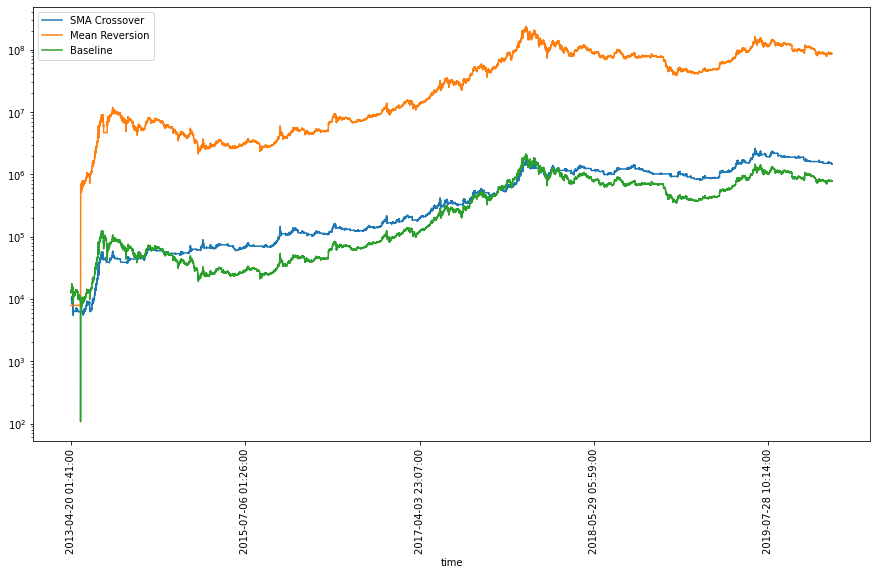

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8

df = sma_crossover_backtest_results['balance_data']
df = df.merge(mean_reversion_backtest_results['balance_data'], on='time', how="left")
df['Baseline'] = df['Baseline_y']
df = df.drop(["Baseline_x", "Baseline_y"], axis=1)
df = df.dropna()
df

#view on a log scale
df.plot(x = "time")
plt.xticks(rotation="vertical")
plt.yscale(value="log")
plt.show()

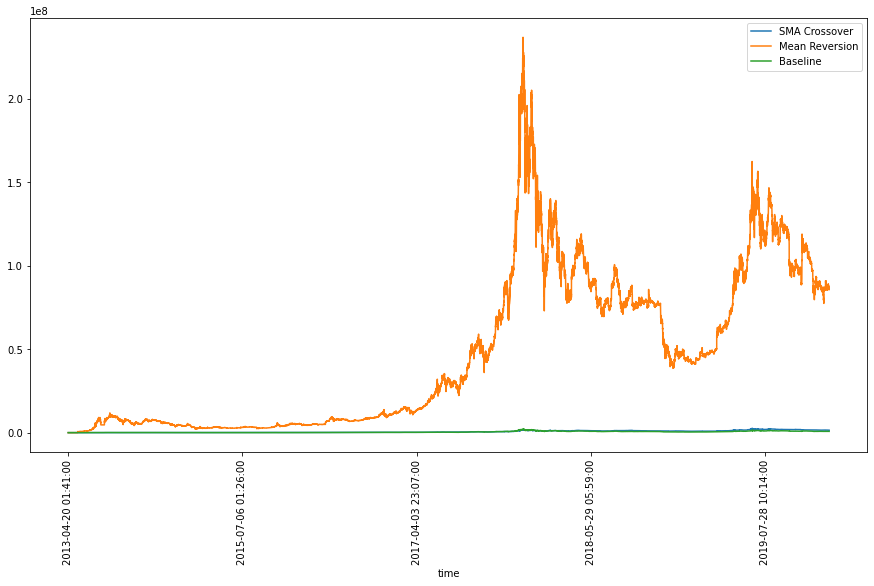

In [73]:
# view on a linear scale
df.plot(x = "time")
plt.xticks(rotation="vertical")
plt.show()